TRABAJO FIN DE MASTER

Máster en Big Data y Data Science

Título: Descubriendo similitud entre documentos a partir de entidades nombradas

Tutor: Pablo A. Haya Coll

Estudiante: Emilio J. Macias Macias

# Fase 2: Mejora del reconocimiento. Evaluación de resultados

En función de los resultados obtenidos en la evaluación de la fase 1, se realizará una mejora del reconocimiento de entidades ya se mediante un entrenamiento o mediante recursos lingüísticos. Será preciso etiquetar nuevos texto para poder entrenar el modelo preentrenado.

## Librerías
Para este prototipo se ha usado la versión de Python 3.7. A continuación se muestran las librerías que se han utilizado:

* **BratReader**: Permite crear la estructura de objetos a partir de un repositorio de ficheros anotados en Brat. Disponible en GitHub con licencia GPL.
* **Spacy**: Permite realizar procesamiento de lenguaje natural en Python, incluyendo reconocimiento de entidades nombradas.
* **Scikit-Learn**: Librería de machine learning que se ha utilizado para construir la matriz de confusión de las entidades nombradas detectadas por Spacy. 
* **Matplotlib**: Se ha utilizado para representar gráficamente la matriz de confusión.
* faltan mas ..............

In [1]:
import evaluation

import spacy
from sklearn.metrics import confusion_matrix

import sys,os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Carga un modelo Spacy del disco local (debe haber sido entrenado y generado anteriormente).
def load_model(tfm_dir, data_size, epoch, dropout, revision_rate):    
    model = spacy.load(tfm_dir + '/models/model_' + data_size + '_e' + str(epoch) + '_d' + str(dropout) + '_r' + str(revision_rate))
    return model

In [2]:
pretrained_model = spacy.load('es_core_news_sm')

# Especificar parámetros para cargar el modelo actualizado:

# Directorio raiz del proyecto.
tfm_dir = str(Path(os.getcwd()).parent)

data_size = 'medium' # small | medium | large
epoch = 4
dropout = 0.5
revision_rate = 0.7

model_name = 'trained_model'

# Cargar modelo actualizado (debe haber sido entrenado y generado anteriormente).
updated_model = load_model(tfm_dir, data_size, epoch, dropout, revision_rate)

In [4]:
# Añadir directorio de la librería bratreader
sys.path.append(tfm_dir + "/bratreader")

# Especificar directorio del Gold Standard con las noticias anotadas.
gs_dir = tfm_dir + "/gold_standard"

# Cargar modelo de anotaciones en Brat
from bratreader.repomodel import RepoModel
brat = RepoModel(gs_dir)

In [5]:
# Evaluar el modelo original pre-entrenado.
gs_vec1, spacy_vec1, f1_score1, precision1, recall1 = evaluation.eval_ner(gs_dir, pretrained_model, brat)

# Evaluar el nuevo modelo actualizado.
gs_vec2, spacy_vec2, f1_score2, precision2, recall2 = evaluation.eval_ner(gs_dir, updated_model, brat)

print("Precision = " + str(round(precision2,3)))
print("Recall = " + str(round(recall2,3)))
print("F1-Score = " + str(round(f1_score2,3)))

Precision = 0.588
Recall = 0.637
F1-Score = 0.611


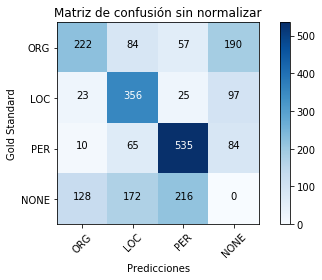

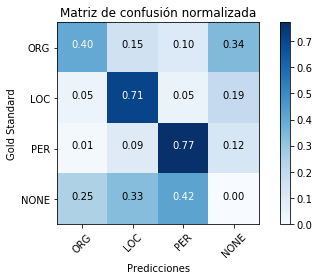

In [6]:
# Mostrar matriz de confusión del modelo actualizado.
class_names = ['ORG', 'LOC', 'PER', 'NONE']

# Matriz del modelo original pre-entrenado.
cnf_matrix1 = confusion_matrix(gs_vec1, spacy_vec1)

# Matriz del nuevo modelo actualizado.
cnf_matrix2 = confusion_matrix(gs_vec2, spacy_vec2)
evaluation.show_conf_matrix(cnf_matrix2, class_names, tfm_dir, model_name)

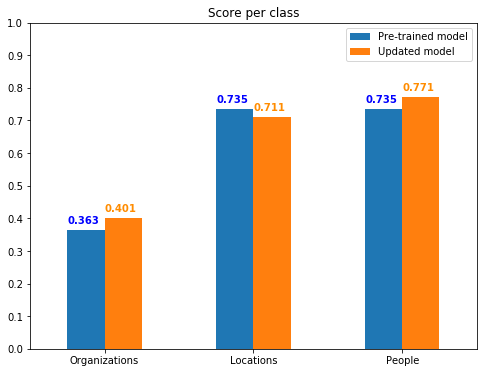

In [7]:
# Comparar resultados de los dos modelos sobre las 3 clases de entidad nombrada.
entity_types = ['Organizations','Locations','People']
models = ['Pre-trained model', 'Updated model']

# Normalizar matrices de confusión.
norm_cnf_matrix1 = cnf_matrix1.astype('float') / cnf_matrix1.sum(axis=1)[:, np.newaxis]
norm_cnf_matrix2 = cnf_matrix2.astype('float') / cnf_matrix2.sum(axis=1)[:, np.newaxis]

# Obtener la diagonal de la matriz (score de cada clase de entidad).
pretrained_score = np.diag(norm_cnf_matrix1)[:3]
new_score = np.diag(norm_cnf_matrix2)[:3]

# Crear dataframe con los valores de las dos matrices.
df = pd.DataFrame(np.c_[pretrained_score,new_score], index=entity_types, columns=models)

# Mostrar diagrama de barras.
ax = df.plot(kind='bar', rot=0, figsize=(8,6))
for i, v in enumerate(pretrained_score):
    ax.text(i - 0.25, v + 0.02, str("%.3f" % v), color='blue', fontweight='bold')
for i, v in enumerate(new_score):
    ax.text(i, v + 0.02, str("%.3f" % v), color='darkorange', fontweight='bold')

plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Score per class')
plt.savefig(tfm_dir + '/img/score_classes_' + model_name + '.png')
#plt.show()

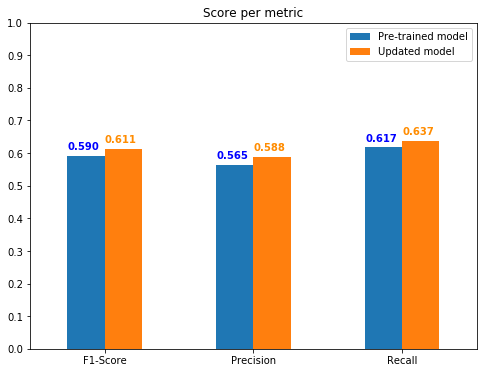

In [8]:
# Comparar resultados de los dos modelos sobre las 3 clases de entidad nombrada.
metrics = ['F1-Score','Precision','Recall']
models = ['Pre-trained model', 'Updated model']

# Obtener la diagonal de la matriz (score de cada clase de entidad).
pretrained_score = [f1_score1, precision1, recall1]
new_score = [f1_score2, precision2, recall2]

# Crear dataframe con los valores de las dos matrices.
df = pd.DataFrame(np.c_[pretrained_score,new_score], index=metrics, columns=models)

# Mostrar diagrama de barras.
ax = df.plot(kind='bar', rot=0, figsize=(8,6))
for i, v in enumerate(pretrained_score):
    ax.text(i - 0.25, v + 0.02, str("%.3f" % v), color='blue', fontweight='bold')
for i, v in enumerate(new_score):
    ax.text(i, v + 0.02, str("%.3f" % v), color='darkorange', fontweight='bold')

plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Score per metric')
plt.savefig(tfm_dir + '/img/score_metrics_' + model_name + '.png')
#plt.show()

Problemas:

* Se ha duplicado el nº de falsos positivos de LOC -> Quitar minúsculas del CSV (palabras demasiado comunes que coinciden con localizaciones.

* Ha bajado el recall (aumento de los falsos negativos para ORG y PER) -> analizar algunos resultados del Matching para ver qué entidades no están en el CSV.

* Muchas organizaciones/personas se confunden con localizaciones -> Analizar las localizaciones más frecuentes en Camel/Mayus detectadas por el Matching.

* Saltos de línea se consideran entidades de tipo ORG !!!!!!! OJO con esto!!


## Conclusiones
...

## Estructura de directorios
..

## Referencias

* Lista de 269K ciudades del mundo: https://docs.google.com/spreadsheets/d/1x-t5GdfxbeuO5GtfnX4BYbTC6XBRI8HgxUfHIclR8bw/edit#gid=674937053
* Lista de 42K organizaciones y 620K nombres de persona: https://ec.europa.eu/jrc/en/language-technologies/jrc-names